# Pairwise thermal classification (baseline vs candidate)


This notebook builds a simple model that compares each image to a normal baseline from the same transformer (data/T*/normal vs data/T*/faulty).


Notes:

- Approach: create a per-transformer baseline (median of all normal images), extract difference features between a candidate and its baseline (legend-aware), and train a small classifier.
- This avoids mixing all transformers together; comparisons are intra-transformer, which is more robust to hardware/background variations.

The following rules, guidelines and table were provided to us and are not created by us.

## Rules

There are two types of abnormal situations observed in the dataset: loose joints and overloads. 

 1. Loose Joint Condition 

    A loose joint creates a hotspot at the connection point. 

- Faulty: If the middle of the joint appears reddish or orange-yellowish, compared to a blue/black background, it is a clear fault.

- Potentially Faulty: If the middle of the joint is yellowish (not reddish or orange) compared to the blue/black background, it is potentially faulty. 


2. Overloaded Condition

    Overloading causes heating along a wire.  

- Point Overload (Faulty): If a small point or small area on the wire appears reddish or orange-yellowish, while the rest of the wire is in black/blue or yellowish, it is a faulty case.  

- Point Overload (Potentially Faulty): If a small point or small area on the wire appears yellowish, while the rest of the wire is in black/blue, it is a potentially faulty case.

- Full Wire Overload (Potentially Faulty): If the entire wire appears in reddish or yellowish colors, it is considered potentially faulty. This could be due to operational load rather than a permanent fault.  

## Guidelines

1. Always compare the hotspot area with its background. A valid anomaly appears when a reddish or yellowish spot contrasts with a mostly blue/black background. When we say “background”, we don’t mean the background of the transformer (e.g., sky, building, or trees). This is the background of the relevant component in the thermal image (parts of the transformer).

2. Use the color intensity and distribution to classify the image into one of the categories:  
   - Normal  
   - Faulty (loose joint/point overload)  
   - Potentially Faulty (yellowish loose joint or full wire overload)  
3. If uncertain, focus on whether the contrast with the background clearly indicates abnormal heating.

4. Objective is to minimize fault negatives because false positives go through a human verification step, but false negatives do not!  

## Summary Table of Thermal Image Analysis

| Condition                | Thermal Image Appearance                                                             | Classification        |
|---------------------------|---------------------------------------------------------------------------------------|-----------------------|
| Normal                   | Mostly black/blue, no reddish or yellowish spots                                       | Normal                |
| Loose Joint (Faulty)     | Middle area reddish / orange-yellowish, background blue/black                          | Faulty                |
| Loose Joint (Potential)  | Middle area yellowish (not reddish/orange), background blue/black                      | Potentially Faulty    |
| Point Overload (Faulty)  | Small spot reddish / orange-yellowish, rest of the wire black/blue or yellowish        | Faulty                |
| Point Overload (Potential)| Small spot yellowish, rest of the wire black/blue                                     | Potentially Faulty    |
| Full Wire Overload       | The entire wire is reddish or yellowish                                               | Potentially Faulty    |


In [ ]:
import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from helpers import ensure_bgr, make_red_mask_hsv, detect_legend_mask, remove_small_components, shorten_path, classify_folder

DATA_ROOT = Path('data')

In [ ]:
def compute_baseline_for_transformer(t_dir: Path) -> np.ndarray:
    """Compute a baseline image for a transformer (median of normal images).
    Returns BGR uint8 image or raises if none found."""
    normals = sorted((t_dir / 'normal').glob('*.*'))
    imgs = []
    for p in normals:
        img = cv.imread(str(p), cv.IMREAD_UNCHANGED)
        if img is None:
            continue
        imgs.append(ensure_bgr(img))
    if not imgs:
        raise FileNotFoundError(f'No normal images found in {t_dir}/normal')
    # Resize to smallest size among normals to align then median
    h_min = min(im.shape[0] for im in imgs)
    w_min = min(im.shape[1] for im in imgs)
    stack = [cv.resize(im, (w_min, h_min), interpolation=cv.INTER_AREA) for im in imgs]
    median = np.median(np.stack(stack, axis=0), axis=0).astype(np.uint8)
    return median

## Simplified warm-spot detection and plotting


This section ignores specific fault types. It:

- Builds a baseline from normal images per transformer.

- Flags warm regions (red, yellow, orange) that exceed the baseline.

- Draws red rectangles around detected warm areas.

- Plots results for review.

In [14]:
def make_warm_mask(img_bgr: np.ndarray) -> np.ndarray:
    """Warm = red OR yellow/orange in HSV."""
    red = make_red_mask_hsv(img_bgr)
    # yellow/orange range
    hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    lower_y = np.array([15, 80, 60], dtype=np.uint8)
    upper_y = np.array([35, 255, 255], dtype=np.uint8)
    yellow = cv.inRange(hsv, lower_y, upper_y)
    warm = cv.bitwise_or(red, yellow)
    return warm

def detect_fault_regions(img_bgr: np.ndarray, baseline_bgr: np.ndarray,
                         min_area_frac: float = 0.0005) -> Tuple[np.ndarray, list]:
    """Return warm mask (legend removed) and list of bounding boxes for warm regions above baseline.
    min_area_frac: fraction of image area; regions below are ignored."""
    H, W = img_bgr.shape[:2]
    # Resize baseline to current
    base = cv.resize(baseline_bgr, (W, H), interpolation=cv.INTER_AREA)
    legend = detect_legend_mask(img_bgr)
    warm_img = make_warm_mask(img_bgr)
    warm_base = make_warm_mask(base)
    # Keep only warm not already warm in baseline
    new_warm = cv.bitwise_and(warm_img, cv.bitwise_not(warm_base))
    # Remove legend
    new_warm = cv.bitwise_and(new_warm, cv.bitwise_not(legend))
    # Clean up
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    new_warm = cv.morphologyEx(new_warm, cv.MORPH_CLOSE, kernel, iterations=1)
    new_warm = remove_small_components(new_warm, min_area=max(5, int(min_area_frac*H*W)))
    # Find boxes
    contours, _ = cv.findContours(new_warm, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    boxes = []
    for cnt in contours:
        x,y,w,h = cv.boundingRect(cnt)
        boxes.append((x,y,w,h))
    return new_warm, boxes

def draw_boxes(img_bgr: np.ndarray, boxes: list) -> np.ndarray:
    vis = img_bgr.copy()
    for (x,y,w,h) in boxes:
        cv.rectangle(vis, (x,y), (x+w, y+h), (0,0,255), 2)
    return vis

In [15]:
# Run across dataset and plot detected faults
def plot_detected_faults(data_root: Path, max_transformers: int = 5, max_samples: int = 8):
    transformers = sorted([p for p in data_root.glob('T*') if p.is_dir()])[:max_transformers]
    results = []
    for t in transformers:
        try:
            baseline = compute_baseline_for_transformer(t)
        except Exception as e:
            print(f"Skip {t.name}: {e}")
            continue
        # Evaluate faulty images (and normals to show no boxes ideally)
        candidates = sorted((t/'faulty').glob('*.*')) + sorted((t/'normal').glob('*.*'))
        for p in candidates[:max_samples]:
            img = cv.imread(str(p), cv.IMREAD_UNCHANGED)
            if img is None:
                continue
            bgr = ensure_bgr(img)
            warm_mask, boxes = detect_fault_regions(bgr, baseline)
            vis = draw_boxes(bgr, boxes)
            results.append((str(p), vis, boxes))
    # Plot grid
    N = len(results)
    if N == 0:
        print('No images to show.')
        return
    cols = 4
    rows = (N + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2))
    axes = np.array(axes).reshape(-1) if rows*cols>1 else np.array([axes])
    for i, ax in enumerate(axes):
        if i < N:
            p, vis, boxes = results[i]
            rgb = cv.cvtColor(vis, cv.COLOR_BGR2RGB)
            ax.imshow(rgb)
            title = 'Fault' if len(boxes)>0 else 'Normal'
            ax.set_title(title, fontsize=9)
            if 'shorten_path' in globals():
                ax.set_xlabel(shorten_path(p), fontsize=7)
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

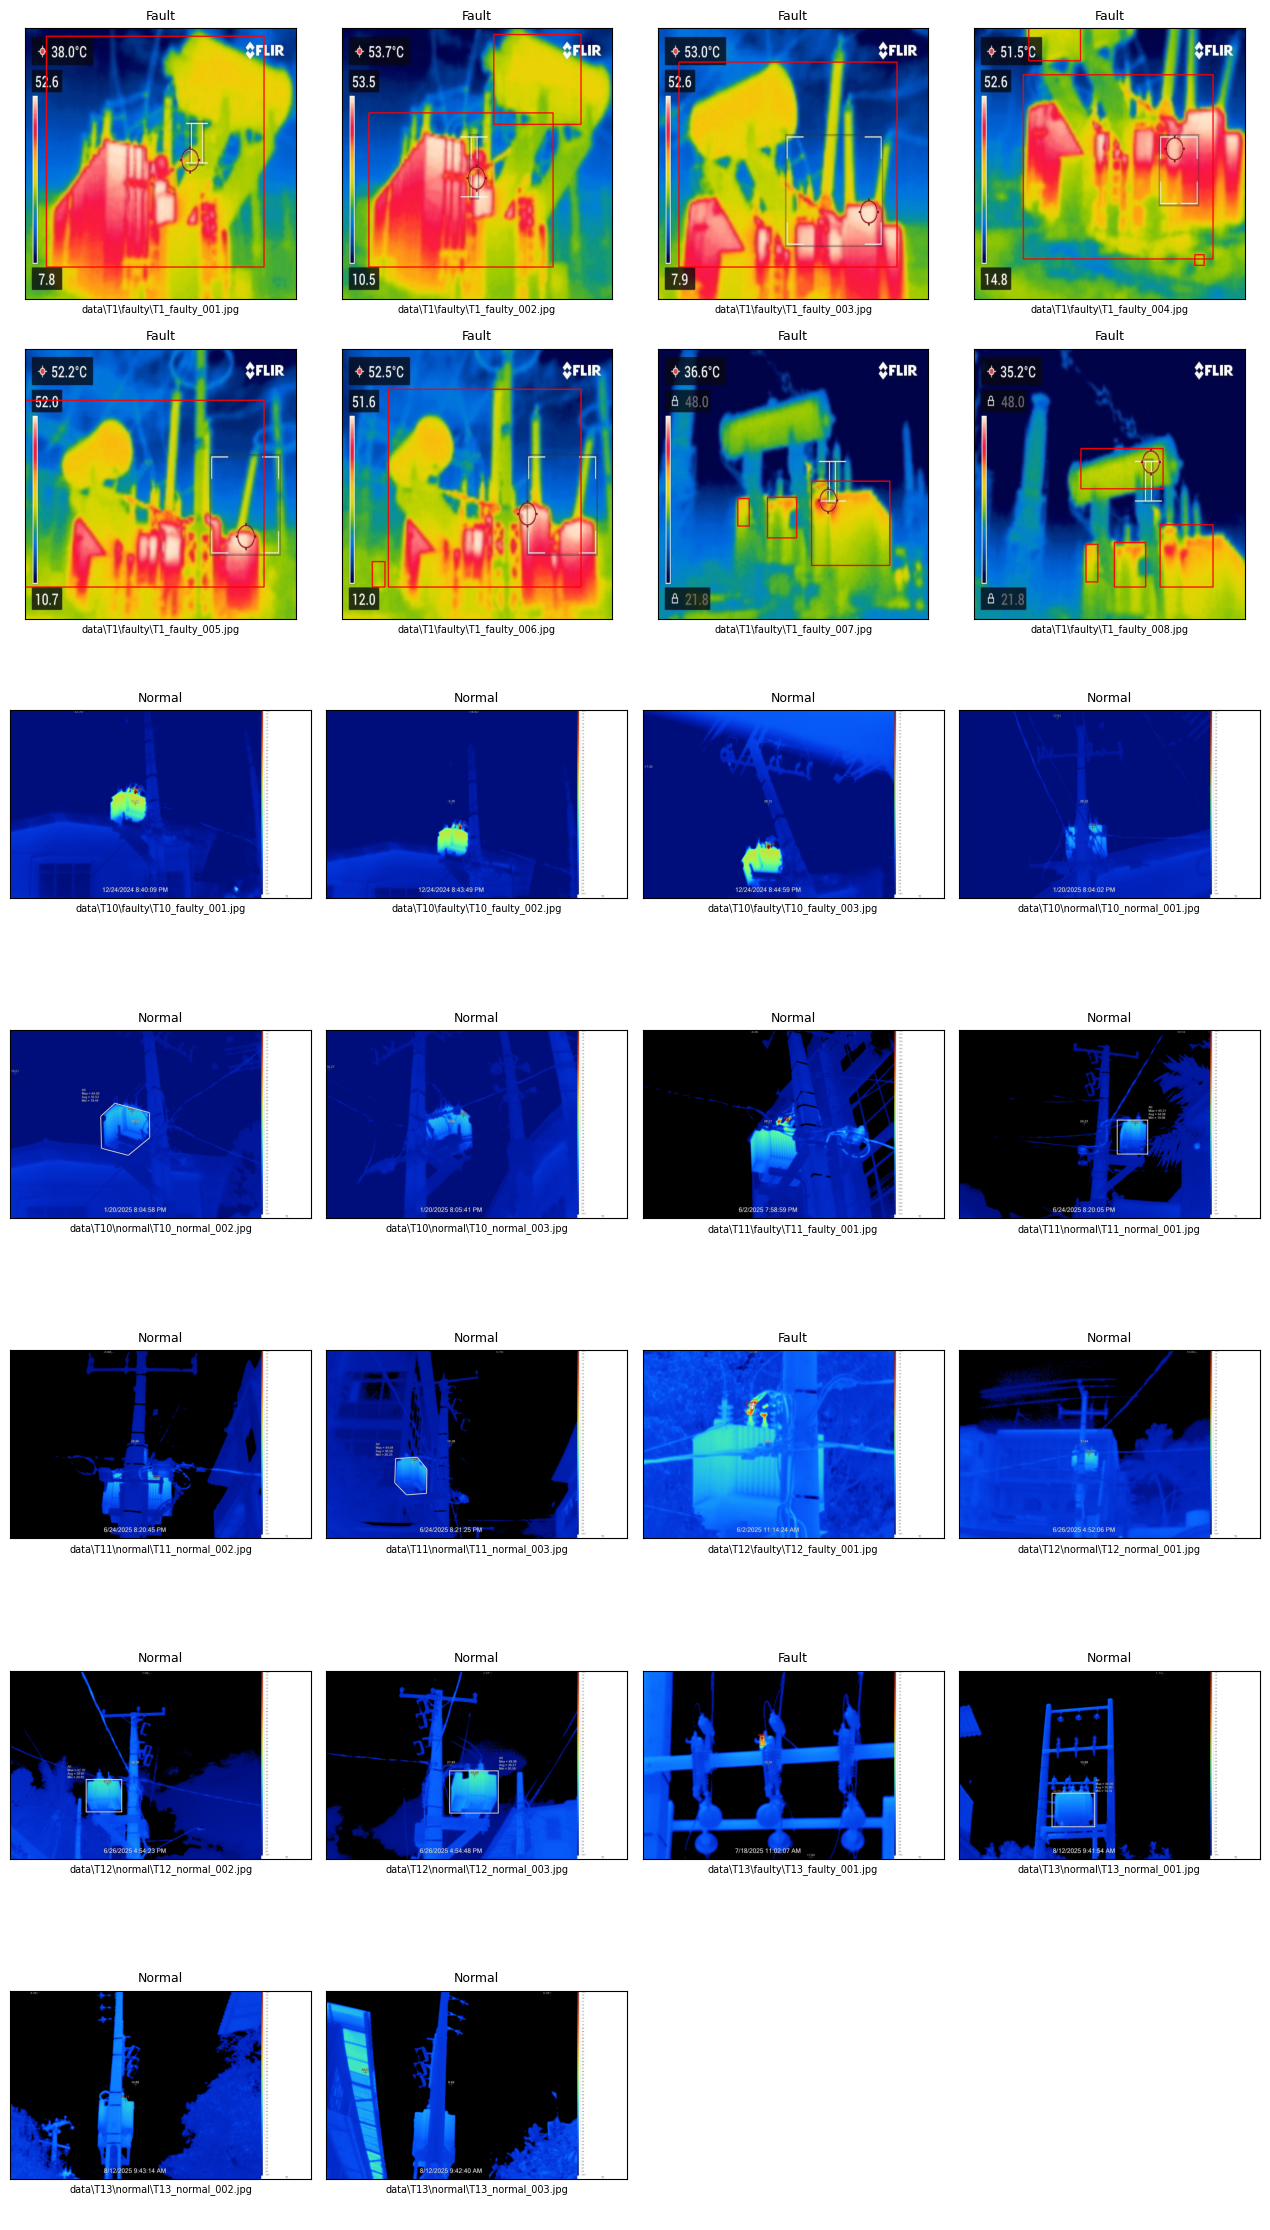

In [16]:
plot_detected_faults(DATA_ROOT)